In [36]:
import tweepy
import pandas as pd
import csv
import re 
import string
import preprocessor as p
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from collections import  Counter
import emoji
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
np.random.seed(42)

# Init general parameters

In [4]:
consumer_key="18GgtxgXKtFNClpxb7iore84G"
consumer_secret="RzqoSkUi5919JWYY2hew6WpTtEXah2PJLOvDwkMFlJfcpS9lgO"
access_token_key="1393585869026697216-HYA8QxK0ShrF9r1mUwzyfm1mqm5Imn"
access_token_secret="h4fVbzG4SgK8yqAL6d18QP4IEEvLyuevEashyprrkfdAp"

In [5]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [37]:
user_ids = ["netanyahu", "meravmichaelijs", "naftalibennett", "tamarzandberg", "yairlapid", "ayelet__shaked", "AvigdorLiberman", "regev_miri", "NitzanHorowitz"]

# Pull data from twitter

In [11]:
data_per_user = dict()
last_id_per_user = dict()
for user_id in user_ids:
    last_id_per_user[user_id] = -1
    data_per_user[user_id] = []
for user_id in user_ids:
    print("WORKING ON " + user_id)
    last_id = None
    while len(data_per_user[user_id]) < 1:
        if last_id_per_user[user_id] != -1:
            last_id = last_id_per_user[user_id]
        tweets = api.user_timeline(screen_name=user_id, count=200, include_rts = False, exclude_replies=True, tweet_mode = 'extended', max_id = last_id)
        pulled_data = [[tweet.id_str, tweet.created_at, tweet.favorite_count, tweet.retweet_count, tweet.full_text.encode("utf-8").decode("utf-8")] for idx,tweet in enumerate(tweets)]
        data_per_user[user_id].extend(pulled_data)
        if len(tweets) == 0:
                break
        last_id_per_user[user_id] = tweets[-1].id
    print("DONE WITH " + user_id)

WORKING ON netanyahu


NameError: name 'api' is not defined

In [ ]:
for user_id in user_ids:
    df = pd.DataFrame(data_per_user[user_id], columns=["id","created_at","favorite_count","retweet_count", "text"])
    df.to_csv('%s_tweets.csv' % user_id,index=False)

# Data Processing

## Data Preview

In [38]:
all_data = pd.DataFrame(columns=["id", "text", "label"])
for user_id in user_ids:
    raw_data = pd.read_csv('%s_tweets.csv' % user_id)
    raw_data["label"] = user_id
    row = raw_data[["id", "text", "label"]]
    all_data = all_data.append(row)
print(all_data)

                       id                                               text  \
0     1400120105783152647  עוד פרטים: https://t.co/rrKuyf4nnA https://t.c...   
1     1400025751848632321  אני מברך את יצחק הרצוג על בחירתו לנשיא המדינה ...   
2     1399768934337945601  הטענה המרכזית בתיק התפור 4000 - קרסה היום בבית...   
3     1399679823786696707  האיום הגדול ביותר עלינו זה האיום הקיומי שמוצב ...   
4     1399670824064462854  למוסד יצא בצדק רב מוניטין של אחד מארגוני הביון...   
...                   ...                                                ...   
2235   886622894738079744  התנגדות המדינה לאימוץ ע״י הורים להטבים מראה שה...   
2236   886279548807110657  עכשיו גם בתל אביב. עדיין רחוק מאוד מהמספרים של...   
2237   885065513096839169  קצת הדתה להיום:\r\nאיכה היתה לזונה קריה נאמנה,...   
2238   884683576662536192  ״ממשלת החלומות של החרדים״ הגדיר את זה @yairche...   
2239   884490381194297344  כוכב הערב - הבן של גבאי. ״אבא יעשה שלטון סוציא...   

               label  
0          netan

## Remove all tweets that are not including hebrew letters

In [39]:
def is_tweet_has_hebrew(text):
    return any("\u0590" <= c <= "\u05EA" for c in text)

non_hebrew = []
hebrew_only = pd.DataFrame(columns=["id", "text", "label"])
for idx, row in all_data.iterrows():
    if not is_tweet_has_hebrew(row["text"]):
        non_hebrew.append(row["text"])
    else:
        row["text"] = row["text"].replace(".", "")
        hebrew_only = hebrew_only.append(row)
print(len(non_hebrew))
print(hebrew_only)

934
                       id                                               text  \
0     1400120105783152647  עוד פרטים: https://tco/rrKuyf4nnA https://tco/...   
1     1400025751848632321  אני מברך את יצחק הרצוג על בחירתו לנשיא המדינה ...   
2     1399768934337945601  הטענה המרכזית בתיק התפור 4000 - קרסה היום בבית...   
3     1399679823786696707  האיום הגדול ביותר עלינו זה האיום הקיומי שמוצב ...   
4     1399670824064462854  למוסד יצא בצדק רב מוניטין של אחד מארגוני הביון...   
...                   ...                                                ...   
2235   886622894738079744  התנגדות המדינה לאימוץ ע״י הורים להטבים מראה שה...   
2236   886279548807110657  עכשיו גם בתל אביב עדיין רחוק מאוד מהמספרים של ...   
2237   885065513096839169  קצת הדתה להיום:\r\nאיכה היתה לזונה קריה נאמנה,...   
2238   884683576662536192  ״ממשלת החלומות של החרדים״ הגדיר את זה @yairche...   
2239   884490381194297344  כוכב הערב - הבן של גבאי ״אבא יעשה שלטון סוציאל...   

               label  
0          n

In [40]:
all_data = hebrew_only

# Num of tweets per user id

In [41]:
all_data.groupby(['label'])['id'].count()

label
AvigdorLiberman    1933
NitzanHorowitz     2213
ayelet__shaked     2237
meravmichaelijs    1632
naftalibennett     2046
netanyahu          1883
regev_miri         2999
tamarzandberg      1827
yairlapid          2529
Name: id, dtype: int64

## Graphs utils functions

In [7]:
def plot_top_non_stopwords_barchart(text, stop):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (len(word)>1 and word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=invert_words(x))

In [8]:
def plot_top_ngrams_barchart(text, n=2):

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=invert_words(x))

In [9]:
def invert_words(words):
    return [w[::-1] for w in words]

def get_hebrew_stopwords():
    stop_path="./heb_stopwords.txt"
    with open(stop_path, encoding="utf-8") as in_file:
        lines=in_file.readlines()
        res=[l.strip() for l in lines]
        print(res[:4])
    return res

stop=get_hebrew_stopwords()
extra_words = ["QA", "the", "and", "to"]
stop += extra_words

# stop = ["א", "ב", "ג", "ד", "ה", "ו", "ז", "ח", "ט", "י", "כ", "ל", "מ", "נ", "ס", "ע", "פ", "צ", "ק", "ר", "ש", "ת"] # TODO: REMOVE!

['את', 'לא', 'של', 'אני']


## Clear data from symbols - emoji, flags, punctuations etc...

In [10]:
my_punctuation = string.punctuation.replace(",", "").replace(".","").replace("?","").replace("!","")
def remove_pe(text, p =string.punctuation):
    text_without = "".join([c for c in text if c not in p])
    text_without_pe =  emoji.get_emoji_regexp().sub(r'', text_without)
    return text_without_pe

def removeWeirdChars(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    return weridPatterns.sub(r'', text)

## Clear hebrew data preview

In [11]:
all_data['text'] = all_data['text'].apply(lambda x: remove_pe(x, my_punctuation))\
                                 .apply(lambda x: re.sub(r'[A-Za-z]|http\S+|[0-9]+', '',x))\
                                 .apply(lambda x: removeWeirdChars(x))
print(all_data)

                       id                                               text  \
0     1400120105783152647                                        עוד פרטים     
1     1400025751848632321  אני מברך את יצחק הרצוג על בחירתו לנשיא המדינה ...   
2     1399768934337945601   הטענה המרכזית בתיק התפור   קרסה היום בבית המשפט    
3     1399679823786696707  האיום הגדול ביותר עלינו זה האיום הקיומי שמוצב ...   
4     1399670824064462854  למוסד יצא בצדק רב מוניטין של אחד מארגוני הביון...   
...                   ...                                                ...   
2235   886622894738079744  התנגדות המדינה לאימוץ ע״י הורים להטבים מראה שה...   
2236   886279548807110657  עכשיו גם בתל אביב עדיין רחוק מאוד מהמספרים של ...   
2237   885065513096839169  קצת הדתה להיום\r\nאיכה היתה לזונה קריה נאמנה, ...   
2238   884683576662536192  ״ממשלת החלומות של החרדים״ הגדיר את זה   איך זה...   
2239   884490381194297344  כוכב הערב  הבן של גבאי ״אבא יעשה שלטון סוציאלי...   

               label  
0          netan

## General data statistics

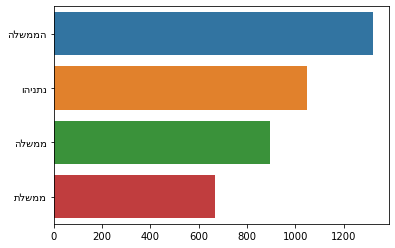

In [27]:
plot_top_non_stopwords_barchart(all_data["text"], stop)

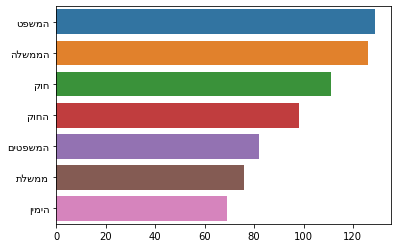

In [28]:
plot_top_non_stopwords_barchart(all_data[all_data["label"]==user_ids[5]]["text"], stop)

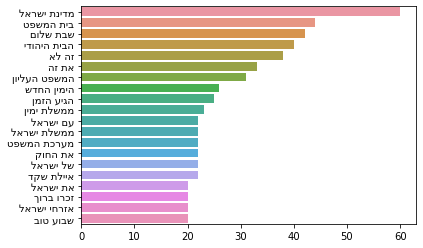

In [29]:
plot_top_ngrams_barchart(all_data[all_data["label"]==user_ids[5]]["text"], 2)

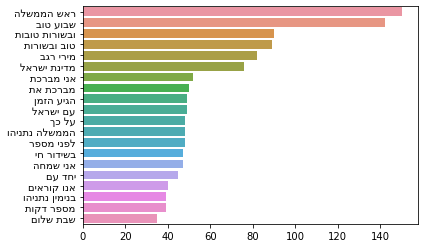

In [30]:
plot_top_ngrams_barchart(all_data[all_data["label"]==user_ids[7]]["text"], 2)

# Yap utils - don't run for now

## Read yap data - for now it's only on 80% from the data and not lovely - takes time to run so we will let it run on the weekend 

In [30]:

# SET TEST AS FULL DATA, CHANGE IT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
all_data_yap_tmp = pd.read_csv("./yap_train.csv")
all_data_yap_tmp_with_label = pd.DataFrame(all_data_yap_tmp, columns=["id", "text", "label"])

for index, row in all_data_yap_tmp_with_label.iterrows():
    full_row = all_data[all_data["id"] == row["id"]]
    all_data_yap_tmp_with_label.loc[index, 'label'] = str(full_row["label"].values[0])
    # print(full_row["label"].values[0])
    print("DONE " + str(index) + " OF " + str(all_data_yap_tmp_with_label.shape[0]))

503 OF 15439
DONE 14504 OF 15439
DONE 14505 OF 15439
DONE 14506 OF 15439
DONE 14507 OF 15439
DONE 14508 OF 15439
DONE 14509 OF 15439
DONE 14510 OF 15439
DONE 14511 OF 15439
DONE 14512 OF 15439
DONE 14513 OF 15439
DONE 14514 OF 15439
DONE 14515 OF 15439
DONE 14516 OF 15439
DONE 14517 OF 15439
DONE 14518 OF 15439
DONE 14519 OF 15439
DONE 14520 OF 15439
DONE 14521 OF 15439
DONE 14522 OF 15439
DONE 14523 OF 15439
DONE 14524 OF 15439
DONE 14525 OF 15439
DONE 14526 OF 15439
DONE 14527 OF 15439
DONE 14528 OF 15439
DONE 14529 OF 15439
DONE 14530 OF 15439
DONE 14531 OF 15439
DONE 14532 OF 15439
DONE 14533 OF 15439
DONE 14534 OF 15439
DONE 14535 OF 15439
DONE 14536 OF 15439
DONE 14537 OF 15439
DONE 14538 OF 15439
DONE 14539 OF 15439
DONE 14540 OF 15439
DONE 14541 OF 15439
DONE 14542 OF 15439
DONE 14543 OF 15439
DONE 14544 OF 15439
DONE 14545 OF 15439
DONE 14546 OF 15439
DONE 14547 OF 15439
DONE 14548 OF 15439
DONE 14549 OF 15439
DONE 14550 OF 15439
DONE 14551 OF 15439
DONE 14552 OF 15439
DONE 14

In [31]:
# SET TEST AS FULL DATA, CHANGE IT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
shuffled_data = all_data_yap_tmp_with_label.sample(frac=1).reset_index(drop=True)

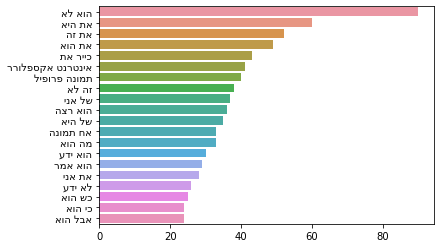

In [58]:
plot_top_ngrams_barchart(all_data_yap_tmp_with_label[all_data_yap_tmp_with_label["label"]==user_ids[1]]["text"],2)

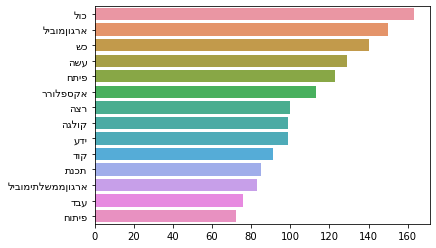

In [57]:
plot_top_non_stopwords_barchart(all_data_yap_tmp_with_label[all_data_yap_tmp_with_label["label"]==user_ids[1]]["text"], stop)

# Prepare data for ML algo

In [12]:
shuffled_data = all_data.sample(frac=1).reset_index(drop=True)

In [13]:
y = shuffled_data["label"]
x = shuffled_data

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_train = y_train.to_frame()
y_test = y_test.to_frame()

## Train data statistics

### netanyahu

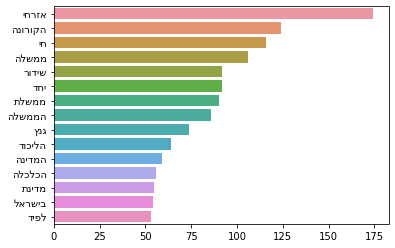

In [71]:
plot_top_non_stopwords_barchart(x_train[x_train["label"]==user_ids[0]]["text"],stop)

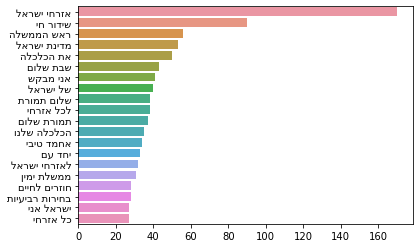

In [62]:
plot_top_ngrams_barchart(x_train[x_train["label"]==user_ids[0]]["text"],2)

### meravmichaelijs

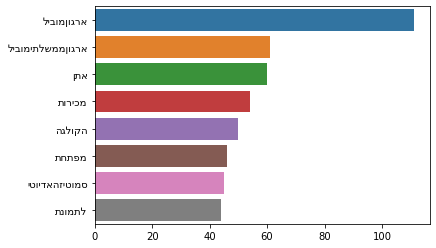

In [72]:
plot_top_non_stopwords_barchart(x_train[x_train["label"]==user_ids[1]]["text"],stop)

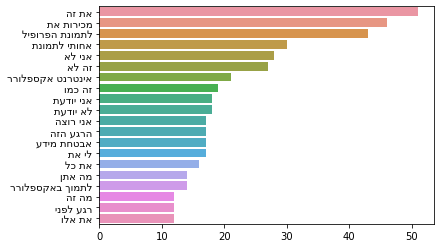

In [67]:
plot_top_ngrams_barchart(x_train[x_train["label"]==user_ids[1]]["text"],2)

### naftalibennett

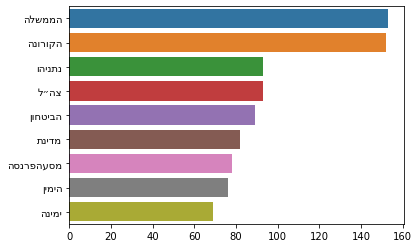

In [73]:
plot_top_non_stopwords_barchart(x_train[x_train["label"]==user_ids[2]]["text"],stop)

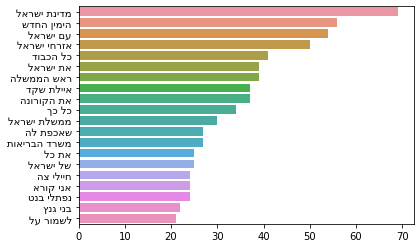

In [70]:
plot_top_ngrams_barchart(x_train[x_train["label"]==user_ids[2]]["text"],2)

### tamarzandberg

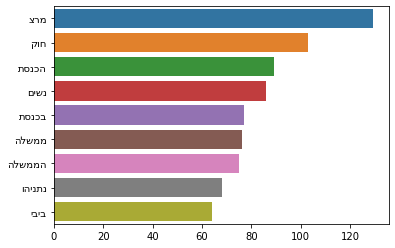

In [75]:
plot_top_non_stopwords_barchart(x_train[x_train["label"]==user_ids[3]]["text"],stop)

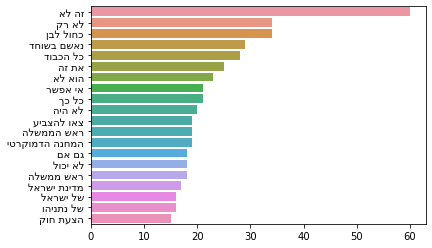

In [76]:
plot_top_ngrams_barchart(x_train[x_train["label"]==user_ids[3]]["text"],2)

### yairlapid

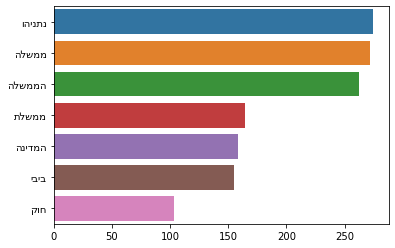

In [82]:
plot_top_non_stopwords_barchart(x_train[x_train["label"]==user_ids[4]]["text"],stop)

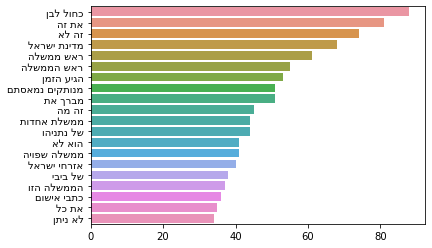

In [83]:
plot_top_ngrams_barchart(x_train[x_train["label"]==user_ids[4]]["text"],2)

### ayelet__shaked

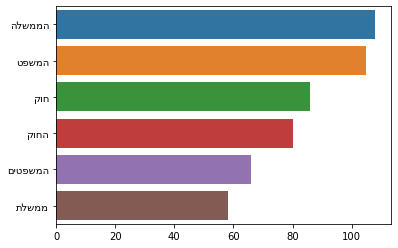

In [84]:
plot_top_non_stopwords_barchart(x_train[x_train["label"]==user_ids[5]]["text"],stop)

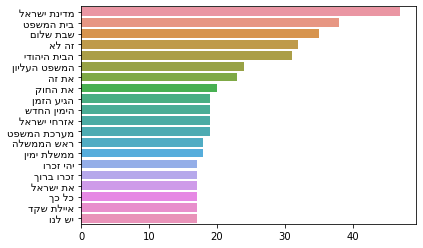

In [85]:
plot_top_ngrams_barchart(x_train[x_train["label"]==user_ids[5]]["text"],2)

### AvigdorLiberman

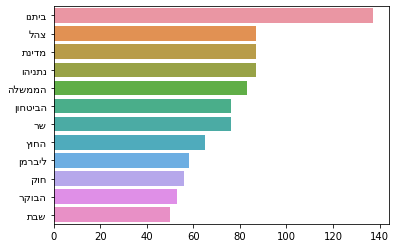

In [86]:
plot_top_non_stopwords_barchart(x_train[x_train["label"]==user_ids[6]]["text"],stop)

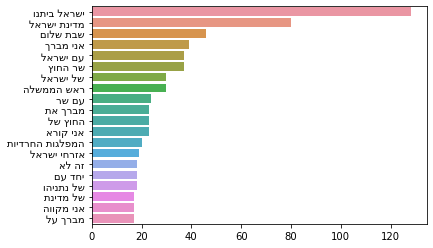

In [87]:
plot_top_ngrams_barchart(x_train[x_train["label"]==user_ids[6]]["text"],2)

### regev_miri

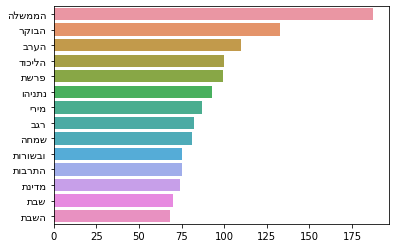

In [88]:
plot_top_non_stopwords_barchart(x_train[x_train["label"]==user_ids[7]]["text"],stop)

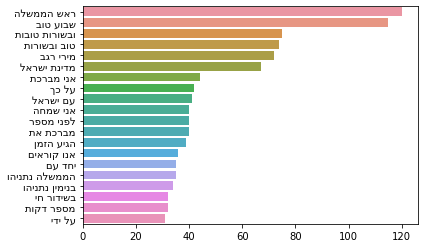

In [89]:
plot_top_ngrams_barchart(x_train[x_train["label"]==user_ids[7]]["text"],2)

### NitzanHorowitz

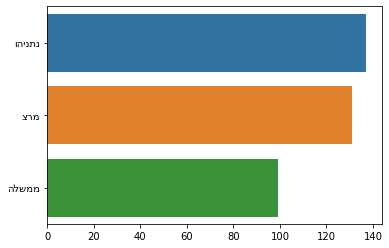

In [90]:
plot_top_non_stopwords_barchart(x_train[x_train["label"]==user_ids[8]]["text"],stop)

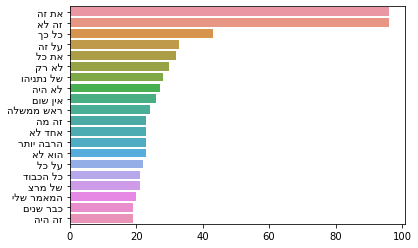

In [91]:
plot_top_ngrams_barchart(x_train[x_train["label"]==user_ids[8]]["text"],2)

In [42]:
# Modify y_test shape to fit evaluator
y_test.loc[:,"text"]=x_test["text"]
y_test = y_test.rename(columns={"label": "label"})

In [43]:
from evaluate import Evaluator
evaluator=Evaluator(y_test)

test_df has 3860 rows


# Yap - Data creation

In [162]:
sys.path.append("C:\HNLP\Ex3\YAP-Wrapper-master")
from yap_api import YapApi

class Processor:
    def __init__(self):
        #replace MY_TOKEN with the token you got from the langndata website
        self.yap_token="a073769bd24ead12455d64d220c0287b"
        self.ip='127.0.0.1:8000'
        self.yap=YapApi() 
        
    def get_yap_analysis(self, text):
        text= text.replace(r'"', r'\"')
        tokenized_text, segmented_text, lemmas, dep_tree, md_lattice, ma_lattice=self.yap.run(text, self.ip)                 
        dep_tree.set_index("num",inplace=True)
        print(type(lemmas))
        return lemmas
 

In [2]:
processor=Processor()

all_data_yap = pd.DataFrame(all_data)
for index, row in all_data_yap.iterrows():
    yap_result = processor.get_yap_analysis(row["text"])
    all_data_yap.loc[index, 'text'] = yap_result
    print("DONE " + str(index) + " OF " + str(all_data_yap.shape[0]))



NameError: name 'Processor' is not defined

In [170]:
all_data_yap.to_csv("all_data_yap_shape.csv")

In [173]:
print(all_data_yap)

                        id                                               text
18708  1111991949114990599  שנה ה חמישים , שלח ה מוסד ב לונדון ב ה תמונה א...
15134  1096824496751865857  חיבור גנץ ניסנקורן ניחש מה זה נעשה ל תלוש ה חש...
14332   563412225189494785  אחרי יום ארוך , שימח ו מלא חוויה ב הוא פגש מאה...
8486   1284897196240973827  ב ה קיצור , ביב חירטט סתם שלף מ ה מותן בלי ה כ...
6612   1368278363115229188  תוכנית ריסטארט ל ה חינוך ב ישראל הקורונה חשף כ...
...                    ...                                                ...
11284  1296400835044429827  ב רוך ה הודה ל כול רבבה ה איש ה טוב ש נלחם למע...
11964  1253710145248530450  ב ה שבת ש בין יום ה שואה ל יום ה זיכרון ל חלל ...
5390   1259857453711310855  שר ו סגן שר ה ממשלה ה גדול ב תולדה ה מדינה הוק...
860     616258528542633984  הוא ה גאווה ש לן דווקא ב יום אלה ב הוא הוא התמ...
15795  1279881181635522563  הוא ישב עם מומחה , כלכלן , בעל עסק ב כול ה ארץ...

[15439 rows x 2 columns]


In [ ]:
x_train_yap = pd.read_csv("./yap_train.csv")

# ML ALGO - SGD Classifier

In [44]:
count_vectorizer=CountVectorizer(analyzer='word', ngram_range=(1, 2))
transformer=TfidfTransformer()
algo= SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-4, n_iter_no_change=20, random_state=42)
pipe = Pipeline([('vectorizer', count_vectorizer),
                    ('transformer', transformer),
                 ('algo', algo)])
pipe.fit(x_train["text"], y_train["label"])
predicted = pipe.predict(x_test["text"])
evaluator.evaluate(predicted)

Micro precision:0.6743523316062177, recall:0.6743523316062177, f1:0.6743523316062177
Macro precision:0.6854150819944915, recall:0.6757673710583704, f1:0.6755550507617111
Accuracy: 0.6743523316062177
[[279   1  15   6  16  13  12  28   9]
 [  2 278   0   4   5   8   2  11  20]
 [ 14   3 294   5  18  16   6  20  16]
 [  2   5  10 211  32  10   6  21  53]
 [ 19   1  20  19 369  10  17  35  37]
 [ 22  10  56  25  32 197  17  70  35]
 [ 20   3  16  10  30  29 211  46  22]
 [ 25   6  19  12  16  21  25 447  29]
 [  6   2  12  30  23  13   5  23 317]]
LABEL:  netanyahu F1:  0.7265625000000001  PREC:  0.7172236503856041  REC:  0.7361477572559367
LABEL:  meravmichaelijs F1:  0.8701095461658841  PREC:  0.8996763754045307  REC:  0.8424242424242424
LABEL:  naftalibennett F1:  0.7050359712230216  PREC:  0.665158371040724  REC:  0.75
LABEL:  tamarzandberg F1:  0.6279761904761904  PREC:  0.65527950310559  REC:  0.6028571428571429
LABEL:  yairlapid F1:  0.6910112359550562  PREC:  0.6820702402957486  R

In [98]:
evaluator.show_errors(predicted, 10, "regev_miri")

overall, there are 155 instances with wrong kind
טוב היה אילו בג״צ היה נמנע בכלל מלהתערב בחוק המסתננים
אני מקווה כי התערבותו לא תפגע בהחזרתם של המסתננים לארץ מוצאם   true:  regev_miri predicted:  ayelet__shaked

בתקופת הקורונה המאתגרת  משרד התחבורה וחברת נתיבי איילון עובדים מסביב לשעון כדי שתוכלו תמיד להנות מתחבורה מתקדמת, מנתיבים מהירים, מרמזורים חכמים ומתשתיות בטוחות אנחנו מחברים את ישראל  בשבילכם צפו  true:  regev_miri predicted:  netanyahu

״איך יהיה למסתנן חלון זמן למלא את חייו בתוכן? הוא שואל ״כיצד יכיר בן או בת זוג? הוא מקשה השיא מגולם בשאלה  true:  regev_miri predicted:  NitzanHorowitz

הפכתי להיות בכיינית בכל פעם שאני מדברת על הורי, כנראה שככל שמתבגרים הוקרת הטוב להורים רק הולכת ומתעצמת 
הערב  true:  regev_miri predicted:  meravmichaelijs

גנץ תלמד להפסיד בכבוד, הפסדת זוהי הדמוקרטיה קבל את הכרעת הציבור  לא ניתן לך לגנוב את הבחירות  true:  regev_miri predicted:  yairlapid

למרות הסכנה נמשיך להיות יהודים גאים, ולא נשנה את אורח החיים נמשיך לחבוש כיפה על ראשנו, נמשיך ללכת לבית הכנ

# ML ALGO - Logistic Regression

In [45]:
count_vectorizer=CountVectorizer(analyzer='word', ngram_range=(1, 2))
transformer=TfidfTransformer()
algo = LogisticRegression(max_iter=100)
pipe = Pipeline([('vectorizer', count_vectorizer),
                    ('transformer', transformer),
                 ('algo', algo)])
pipe.fit(x_train["text"], y_train["label"])
predicted = pipe.predict(x_test["text"])
evaluator.evaluate(predicted)

D:\Users\yelfs\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Micro precision:0.6233160621761658, recall:0.6233160621761658, f1:0.6233160621761658
Macro precision:0.6676984730461195, recall:0.6152578155597557, f1:0.6244369643995751
Accuracy: 0.6233160621761658
[[254   2  17   6  20  11  12  47  10]
 [  2 249   0   6   9  11   0  25  28]
 [ 11   0 262   0  28  22   3  42  24]
 [  3   3  10 150  55  12   2  35  80]
 [ 13   1  20  14 358   6  12  64  39]
 [ 13   8  48  14  46 170  15 102  48]
 [ 15  

In [ ]:
evaluator.show_errors(predicted, 10, "regev_miri")

In [20]:
inverse_dict={count_vectorizer.vocabulary_[w]:w for w in count_vectorizer.vocabulary_.keys()}

In [33]:
def get_strongest_words(label):
    cur_coef=pipe["algo"].coef_[label]
    word_df=pd.DataFrame({"val":cur_coef}).reset_index().sort_values(["val"],ascending=[False])
    word_df.loc[:, "word"]=word_df["index"].apply(lambda v:inverse_dict[v])
    print(word_df.head(10))

In [34]:
# netanyahu
get_strongest_words(0)

         index       val         word
35123    35123  4.386677        ביתנו
156762  156762  3.447670  ישראל ביתנו
184003  184003  3.244018       ליברמן
259653  259653  2.729928          צהל
73184    73184  2.261631         החוץ
14831    14831  1.945780     אני מברך
109524  109524  1.500705        התורה
75122    75122  1.421162      החרדיות
186238  186238  1.398358       לכל עם
182723  182723  1.357426        לחמאס


In [35]:
# meravmichaelijs
get_strongest_words(1)

         index       val     word
161620  161620  2.224297  כחוללבן
246350  246350  2.175101    עכשיו
94746    94746  1.907204   הסיפוח
54949    54949  1.883939      גשר
71260    71260  1.654983      הזה
81338    81338  1.654736      הכי
200425  200425  1.585144     מאוד
70868    70868  1.570087  הורוביץ
73941    73941  1.501770   החינוך
147480  147480  1.491579    טראמפ


In [25]:
# naftalibennett
get_strongest_words(2)

         index       val         word
91465    91465  3.549049      המשפטים
213871  213871  3.213486         מיטל
278867  278867  2.658787       שופטים
91247    91247  2.491058        המשפט
153413  153413  2.323798        ימינה
145850  145850  2.204702           טב
77350    77350  2.111782       היהודי
296012  296012  2.094156          שקד
63605    63605  2.032547  הבית היהודי
106805  106805  1.745206        השופט


In [26]:
# tamarzandberg
get_strongest_words(3)

         index       val              word
17259    17259  7.764950        ארגוןמוביל
17360    17360  5.086884  ארגוןממשלתימוביל
102498  102498  4.020494            הקולגה
183521  183521  3.993547                לי
17083    17083  3.914434          אקספלורר
22400    22400  3.460377               באג
241684  241684  3.343067     סמוטיזהאדיוטי
22168    22168  3.241062               אתן
166850  166850  3.236597              כשאת
215500  215500  3.173888            מכירות


In [27]:
# yairlapid
get_strongest_words(4)

         index       val        word
220335  220335  4.750168   מסעהפרנסה
156604  156604  3.884017       ישראל
102665  102665  3.756251     הקורונה
153413  153413  3.505667       ימינה
259511  259511  3.491460          צה
200318  200318  3.273552         מאד
72702    72702  3.119058        החדש
26492    26492  2.978488      בדיקות
79524    79524  2.862863  הימין החדש
166512  166512  2.838375        כרגע


In [28]:
# ayelet__shaked
get_strongest_words(5)

         index       val         word
156604  156604  4.517484        ישראל
5713      5713  3.979220  אזרחי ישראל
5698      5698  3.635650        אזרחי
288370  288370  3.304729         שלנו
102665  102665  3.255153      הקורונה
280556  280556  3.050082        שידור
286945  286945  3.016328         שלום
280560  280560  2.931572     שידור חי
14591    14591  2.909993          אני
180103  180103  2.898647       להתחסן


In [29]:
# AvigdorLiberman
get_strongest_words(6)

         index       val        word
62357    62357  4.292056       הבוקר
258554  258554  3.946052        פרשת
290168  290168  3.221080        שמחה
214954  214954  2.969282        מירי
267280  267280  2.967594         רגב
111395  111395  2.865926      התרבות
106400  106400  2.864520        השבת
203092  203092  2.778790       מברכת
287027  287027  2.766634  שלום ישראל
272996  272996  2.598636        שבוע


In [30]:
# regev_miri
get_strongest_words(7)

         index       val    word
226227  226227  5.935616     מרצ
237881  237881  2.923834    נשים
583        583  2.532458     אבל
168138  168138  2.517609      לא
48644    48644  2.432665   בשוחד
11999    11999  2.356325  אלימות
114640  114640  1.897151    ובכן
159241  159241  1.894091    כבוד
289230  289230  1.860719    שמאל
241249  241249  1.828181   סיפוח


In [31]:
# NitzanHorowitz
get_strongest_words(8)

         index       val     word
32011    32011  4.511456     ביבי
238528  238528  4.074069   נתניהו
217741  217741  3.655231    ממשלה
218971  218971  3.544103  מנותקים
168138  168138  3.237649       לא
295431  295431  3.191607    שפויה
203077  203077  2.874545     מברך
88079    88079  2.816470   הממשלה
14099    14099  2.559420    אנחנו
235411  235411  2.480864   נמאסתם


# Keras

In [103]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [104]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train["label"])
encoded_Y = encoder.transform(y_train["label"])

In [112]:
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
print(dummy_y.shape)

(15439, 9)


In [114]:
encoder.fit(y_test["label"])
encoded_Y_test = encoder.transform(y_test["label"])
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
print(dummy_y_test.shape)

(3860, 9)


In [106]:
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=200, activation='relu'))
	model.add(Dense(9, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [107]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

In [108]:
kfold = KFold(n_splits=10, shuffle=True)

In [109]:
print(x_train["text"])

18708    אום אל פאחם מדוע שוב התוצאה של הפגנה נגד הפשע ...
15134    הסכמי השלום ההיסטוריים שהבאנו מתקדמים במהירות ...
14332    ממשלה שגורמת לאזרחים שלה לעבור על החוק בלית בר...
8486     היום השתתפתי בהפגנה ב״חץ השחור״ שבה מציינים את...
6612                              רק שלא נתעורר מאוחר מדי 
                               ...                        
11284    חוזרת למשרד מלאת אנדרנלין אחרי יום מדהים בוינג...
11964    מחר, בכנסת, יש לנו הזדמנות לעשות היסטוריה ישרא...
5390     אם הליכוד יהיה גדול, תקום ממשלת שמאל רק ימינה ...
860      תודה לכל הנשים המדהימות שהגיעו לרוץ איתנו היום...
15795    אני לא מכירה צורה כזו של פרוק מונוליט ל  , אך ...
Name: text, Length: 15439, dtype: object


In [134]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["text"])

X_train = tokenizer.texts_to_sequences(x_train["text"])
X_test = tokenizer.texts_to_sequences(x_test["text"])

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

x_train_tok = pad_sequences(X_train, padding='post', maxlen=maxlen)
x_test_tok = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(x_train_tok.shape)

(15439, 200)


In [131]:
x_train_tokens = pd.DataFrame(columns=["text"])
x_train_tokens["text"] = x_train_tok.tolist()

x_test_tokens = pd.DataFrame(columns=["text"])
x_test_tokens["text"] = x_test_tok.tolist()

y_train_vec = pd.DataFrame(columns=["label"])
y_train_vec["label"] = dummy_y.tolist()

y_test_vec = pd.DataFrame(columns=["label"])
y_test_vec["label"] = dummy_y_test.tolist()


(15439, 1)
(15439, 1)


In [135]:
results = cross_val_score(estimator, x_train_tok, dummy_y, cv=kfold)

In [137]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 15.80% (0.94%)


# Keras - with hebrew trained model for word2vec

In [139]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import zipfile
import gensim
from numpy import array
from numpy import asarray
from numpy import zeros

D:\Users\yelfs\AppData\Local\Programs\Python\Python36\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [140]:

nlpl_zip="./47.zip"
with zipfile.ZipFile(nlpl_zip, "r") as archive:
    stream = archive.open("model.bin")
    word_vectors = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True, unicode_errors='replace')

In [141]:
embedding_matrix = zeros((vocab_size, 100))
skip_counter = 0
for word, index in tokenizer.word_index.items():
    print("index: " + str(index) + " of " + str(vocab_size))
    strip_word = word.strip()
    if strip_word != '':
        try:
            embedding_vector = word_vectors.get_vector(strip_word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
        except:
            print("SKIPPING " + word)
            skip_counter += 1
            continue
print("SKIPPED " + str(skip_counter))        

ING מנדבך
index: 55579 of 56269
index: 55580 of 56269
index: 55581 of 56269
index: 55582 of 56269
index: 55583 of 56269
SKIPPING לשברו
index: 55584 of 56269
SKIPPING להכנת
index: 55585 of 56269
SKIPPING והתערבות
index: 55586 of 56269
SKIPPING קרעימארק
index: 55587 of 56269
SKIPPING בשליחותו
index: 55588 of 56269
SKIPPING לשליטה
index: 55589 of 56269
index: 55590 of 56269
SKIPPING באמצעותו
index: 55591 of 56269
index: 55592 of 56269
index: 55593 of 56269
SKIPPING שעורכים
index: 55594 of 56269
index: 55595 of 56269
index: 55596 of 56269
index: 55597 of 56269
index: 55598 of 56269
SKIPPING גאונים
index: 55599 of 56269
SKIPPING והסוחרים
index: 55600 of 56269
index: 55601 of 56269
index: 55602 of 56269
index: 55603 of 56269
index: 55604 of 56269
SKIPPING והפיטפוטים
index: 55605 of 56269
index: 55606 of 56269
SKIPPING ברמדאן
index: 55607 of 56269
SKIPPING يشرفني
index: 55608 of 56269
SKIPPING باسمي
index: 55609 of 56269
SKIPPING وباسم
index: 55610 of 56269
SKIPPING وكوادره
index: 55611 of 56

In [142]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(9, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          5626900   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_20 (Dense)             (None, 9)                 1161      
Total params: 5,745,309
Trainable params: 118,409
Non-trainable params: 5,626,900
_________________________________________________________________
None


In [143]:
encoded_y_vec = []
for label in encoded_Y:
    y_rep = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    y_rep[label - 1] = 1
    encoded_y_vec.append(y_rep)
encoded_y_vec = np.array(encoded_y_vec)

In [144]:
print(x_train_tok)

[[ 5908   113  8773 ...     0     0     0]
 [ 3571   501 12901 ...     0     0     0]
 [   29 12902  1475 ...     0     0     0]
 ...
 [   22    90   110 ...     0     0     0]
 [   84    58   956 ...     0     0     0]
 [    9     4  2739 ...     0     0     0]]


In [145]:
history = model.fit(x_train_tok, encoded_y_vec, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
97/97 [==============================] - 28s 286ms/step - loss: 0.3813 - acc: 0.1427 - val_loss: 0.3467 - val_acc: 0.1597
Epoch 2/5
97/97 [==============================] - 28s 289ms/step - loss: 0.3476 - acc: 0.1477 - val_loss: 0.3478 - val_acc: 0.1367
Epoch 3/5
97/97 [==============================] - 28s 289ms/step - loss: 0.3474 - acc: 0.1503 - val_loss: 0.3468 - val_acc: 0.1597
Epoch 4/5
97/97 [==============================] - 29s 300ms/step - loss: 0.3474 - acc: 0.1539 - val_loss: 0.3468 - val_acc: 0.1597
Epoch 5/5
97/97 [==============================] - 29s 300ms/step - loss: 0.3473 - acc: 0.1563 - val_loss: 0.3470 - val_acc: 0.1597


In [146]:
print(x_train.shape)

(15439, 3)


In [147]:
from keras.layers import SpatialDropout1D

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=200))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64




In [148]:
history = model.fit(x_train_tok, encoded_y_vec, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
218/218 [==============================] - 110s 505ms/step - loss: 2.1831 - accuracy: 0.1549 - val_loss: 2.1797 - val_accuracy: 0.1606
Epoch 2/5
218/218 [==============================] - 110s 503ms/step - loss: 2.1820 - accuracy: 0.1575 - val_loss: 2.1795 - val_accuracy: 0.1606
Epoch 3/5
218/218 [==============================] - 111s 511ms/step - loss: 2.1817 - accuracy: 0.1575 - val_loss: 2.1795 - val_accuracy: 0.1606
Epoch 4/5
218/218 [==============================] - 115s 526ms/step - loss: 2.1815 - accuracy: 0.1575 - val_loss: 2.1785 - val_accuracy: 0.1606
Epoch 5/5
218/218 [==============================] - 118s 543ms/step - loss: 2.1812 - accuracy: 0.1575 - val_loss: 2.1788 - val_accuracy: 0.1606
